In [0]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [0]:
#Loading the file
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Data Exploration And Analysis

In [0]:
#Viewing the Data
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
print("The SHAPE OF DATA: ",df_train.shape)

The SHAPE OF DATA:  (891, 12)


In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


1. Here we can see that Age and Cabin has maximum null values which need to be treated!

In [0]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. Here we can see that Age min value is 0.42 which is   impossible which needs to be treated.
2. And we can observe that in Fare there are outliers present as the max value is 512 Rs but at 75% its just 31 Rs. so need to observe that

In [0]:
#Checking the Numeric Columns & Categorical Colummns
numeric_val = df_train._get_numeric_data()
cat_val = set(df_train.columns) - set(numeric_val)

print("Numeric Columns : ",numeric_val.columns)
print("Categorical Columns : ",cat_val)

Numeric Columns :  Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Categorical Columns :  {'Ticket', 'Embarked', 'Cabin', 'Name', 'Sex'}


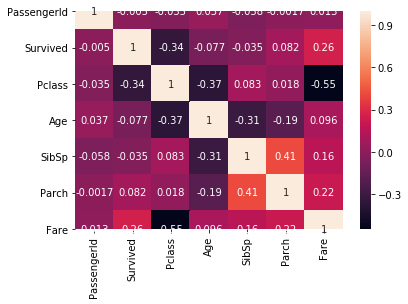

In [0]:
cor = df_train.corr()
sns.heatmap(cor,annot = True)

We can see that Sibsp & Parch are highly correlated which needs to be taken care of!

## Missing Value Imputation

In [0]:
#Checking for NA values
def check_null(df):
  print(df.isnull().sum())

print("TRAIN DATA")  
print("---------------")
check_null(df_train)

print("\nTEST DATA")
print("---------------")
check_null(df_test)

TRAIN DATA
---------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

TEST DATA
---------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


**Train**
1. Age : Imputing by mean. Because Average age can be
considered over here.
2. Cabin : Creating new feature where it is null it will be
0 and where not 1 because only 206 values are not null
3. Embarked: Has only 2 null values which can be replaced with mode


---


**Test**
1. Age : Same way as train treated
2. Fare : Remove the row as only one row out of 891
3. Cabin : Same as Train treated


 



In [0]:
#Replacing Embark missing values with mode
def replacing_mode(ecol):
  max_val = ecol.mode()
  ecol = ecol.fillna(max_val[0])
  return ecol
  
df_train["Embarked"] = replacing_mode(df_train["Embarked"])


In [0]:
#Replacing  Age missing Values with mean
def replacing_mean(ecol):
  avg_val = ecol.median()
  ecol = ecol.fillna(int(avg_val))
  return ecol

df_train["Age"] = replacing_mean(df_train["Age"])
df_test["Age"] = replacing_mean(df_train["Age"])

In [0]:
#Filling the Fare column with mean
df_test["Fare"] = df_test.fillna(0)

## Feature Engineering 

In [0]:
#Generating new Feature for Cabin
df_train["Cabin_notnull"] = np.where(df_train["Cabin"].isnull(),0,1)
df_test["Cabin_notnull"] = np.where(df_test["Cabin"].isnull(),0,1)

df_train = df_train.drop("Cabin",axis = 1)
df_test =  df_test.drop("Cabin",axis = 1)

In [0]:
#Analysis with name
for i in df_train["Name"]:
  df_train["Initial"]= df_train.Name.str.extract('([A-Za-z]+)\.')

In [0]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [0]:
# Combining Sibsp & Parch for removing multi-collinearity
df_train["tot_members"] = df_train["SibSp"] + df_train["Parch"]
df_test["tot_members"] = df_test["SibSp"] + df_test["Parch"]

df_train = df_train.drop(["SibSp",'Parch'],axis = 1)
df_test =  df_test.drop(["SibSp","Parch"],axis = 1)

In [0]:
#Converting Sex feature
df_train["Sex"] = np.where(df_train["Sex"] == 'male',1,0)
df_test["Sex"] = np.where(df_test["Sex"] == 'male',1,0)

In [0]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Cabin_notnull,Initial,tot_members
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,S,0,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C,1,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,S,0,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,S,1,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,S,0,Mr,0


## EDA

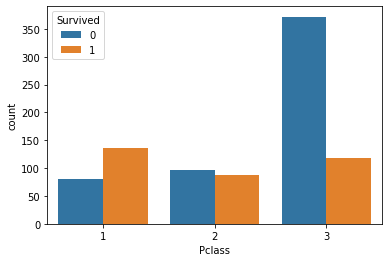

In [0]:
#Checking the Pclass
sns.countplot(x = df_train.Pclass ,hue = df_train.Survived, data = df_train)

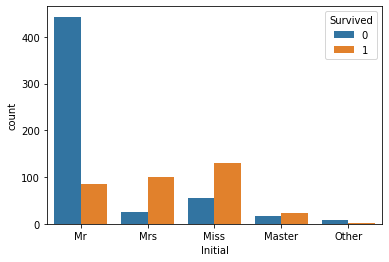

In [0]:
sns.countplot(x = df_train["Initial"], hue = df_train["Survived"])

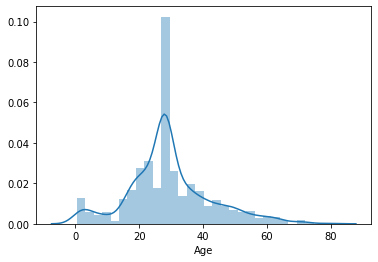

In [0]:
#Age
sns.distplot(df_train["Age"])

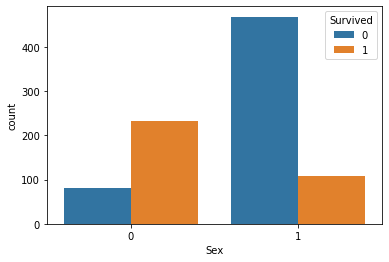

In [0]:
#Sex
sns.countplot(df_train["Sex"],hue = df_train["Survived"])

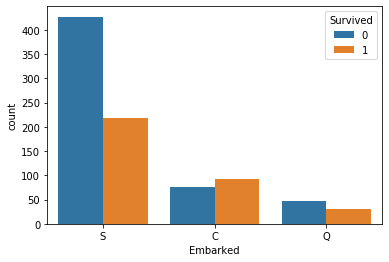

In [0]:
#Embarked
sns.countplot(x = df_train.Embarked , hue = df_train.Survived)

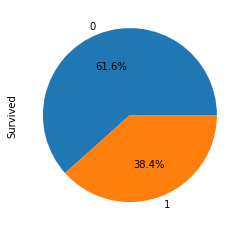

In [0]:
df_train.Survived.value_counts().plot(kind = 'pie',autopct='%1.1f%%')

## Spiliting of Data

### Train Split

In [0]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Cabin_notnull,Initial,tot_members
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,S,0,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C,1,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,S,0,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,S,1,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,S,0,Mr,0


In [0]:
X = df_train[["Pclass","Sex","Age","tot_members","Fare","Cabin_notnull","Embarked"]]
X = pd.get_dummies(data=X,columns=['Embarked'],drop_first=True)
y = df_train["Survived"]
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = 0.3,random_state = 100)

### Test Data Preparation

In [0]:
X_testd = df_test[["Pclass","Sex","Age","tot_members","Fare","Cabin_notnull","Embarked"]]
X_testd = pd.get_dummies(data=X_testd,columns=['Embarked'],drop_first=True)

## Random Forest

In [0]:
rf = RandomForestClassifier()
rf = rf.fit(X_train,Y_train)
rf_pred = rf.predict(X_test)
print("Random Forest",round(accuracy_score(rf_pred,Y_test) * 100 , 2))

Random Forest 81.72


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## XGBOOST

In [0]:
xg = XGBClassifier(random_state=100)
xg.fit(X_train,Y_train)
xg_pred = xg.predict(X_test)
print("XGBOOST",round(accuracy_score(xg_pred,Y_test) * 100 , 2))

XGBOOST 81.72


## Submission File

In [0]:
predict= rf.predict(X_testd)

In [0]:
id = df_test["PassengerId"]
data = pd.DataFrame({"PassengerId" : id , "Survived" : predict})

In [0]:
data.to_csv("Titanic_submission.csv",index = False)